Итак, у нас есть данные с оценками услуг, предоставляемых Федеральными органами исполнительной власти

https://docs.google.com/spreadsheets/d/1_IgEJ7giyc91pxCvJYxOUJk52seVpopt/edit#gid=2087179370 - ссылка на данные

Наша задача заключалась в том, чтобы выяснить, какие из ФОИВ накручивают себе отзывы

https://datastudio.google.com/u/0/reporting/cfd316ca-a58d-40c2-96f7-5c2b7c1ecb77/page/ANghC - здесь мы построили диаграммы для понимания общего уровня удовлетворенности различными ФОИВ и предоставляемыми ими услугами

Подключаем нужные нам библиотеки для работы, скачиваем датасет

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy as sp
import re
import time
import os
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.csv to Dataset.csv


Загрузим данные из .csv файла и ознакомимся с данными:

In [ ]:
data = pd.read_csv('Dataset.csv', low_memory=False)

In [ ]:
data.head()

,ФОИВ,Код ТО ФОИВ,ТО ФОИВ,Уод услуги,Услуга,Факты,Оценки,Уровень удовлетворенности,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
0,Департамент по имущественным и земельным отнош...,9200000000162960901,Департамент по имущественным и земельным отнош...,9200000000167723419,Предварительное согласование предоставления зе...,1.0,2.0,"0,00%",2.0,0.0,0.0,0.0,0.0
1,Главное управление потребительского рынка и ли...,9200000000162963760,Главное управление потребительского рынка и ли...,9200000000167690297,Государственная функция по осуществлению регио...,1.0,7.0,"28,57%",1.0,0.0,0.0,0.0,2.0
2,Департамент здравоохранения Ямало-Ненецкого ав...,8900000000000003078,Департамент здравоохранения Ямало-Ненецкого ав...,8900400000000002972,Запись на прием к врачу в медицинскую организа...,3.0,15.0,"6,67%",12.0,2.0,0.0,1.0,0.0
3,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000010000025881,Выплата средств (части средств) материнского (...,514.0,2717.0,"95,99%",42.0,28.0,39.0,70.0,2538.0
4,Служба записи актов гражданского состояния Яма...,8900000010000003335,Служба записи актов гражданского состояния Яма...,8900000010000004597,Выдача повторных свидетельств о государственно...,123.0,655.0,"100,00%",0.0,0.0,0.0,6.0,649.0


Расшифровка некоторых параметров датасета:

|              	|                                                                          	|
|:------------:	|:-------------------------------------------------------------------------------:	|
| ФОИВ         	| Федеральный орган исполнительной власти                              	|
| cnt_1    	| количество оценок "1"                                       	|
| cnt_2     	| количество оценок "2"                                        	|
| cnt_3    	| количество оценок "3"                                                                  	|
| cnt_4     	| количество оценок "4"                    	|
| cnt_5   	| количество оценок "5"                                                          	|
| Оценки 	| общее количесиво оценок                                                     	|
| Уровень удовлетворенности      	| процентное соотношение оценок "4" и "5" к общему числу оценок                                                	|

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48787 entries, 0 to 48786
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ФОИВ                       48787 non-null  object 
 1   Код ТО ФОИВ                48787 non-null  object 
 2   ТО ФОИВ                    48787 non-null  object 
 3   Уод услуги                 48787 non-null  object 
 4   Услуга                     48787 non-null  object 
 5   Факты                      48786 non-null  float64
 6   Оценки                     48786 non-null  float64
 7   Уровень удовлетворенности  48787 non-null  object 
 8   cnt_1                      48786 non-null  float64
 9   cnt_2                      48786 non-null  float64
 10  cnt_3                      48786 non-null  float64
 11  cnt_4                      48786 non-null  float64
 12  cnt_5                      48786 non-null  float64
dtypes: float64(7), object(6)
memory usage: 4.8+ MB

Посмотрим на количество пропусков по столбцам:

In [ ]:
data.isnull().sum()

ФОИВ                         0
Код ТО ФОИВ                  0
ТО ФОИВ                      0
Уод услуги                   0
Услуга                       0
Факты                        1
Оценки                       1
Уровень удовлетворенности    0
cnt_1                        1
cnt_2                        1
cnt_3                        1
cnt_4                        1
cnt_5                        1
dtype: int64

Удалим строку, в которой есть пропущенное значение:

In [ ]:
data['Факты'].replace('  ', np.nan, inplace=True)

In [ ]:
data= data.dropna(subset=['Факты'])

Убедимся, что пропусков не осталось:

In [ ]:
data.isnull().sum()

ФОИВ                         0
Код ТО ФОИВ                  0
ТО ФОИВ                      0
Уод услуги                   0
Услуга                       0
Факты                        0
Оценки                       0
Уровень удовлетворенности    0
cnt_1                        0
cnt_2                        0
cnt_3                        0
cnt_4                        0
cnt_5                        0
dtype: int64

Корреляция данных:

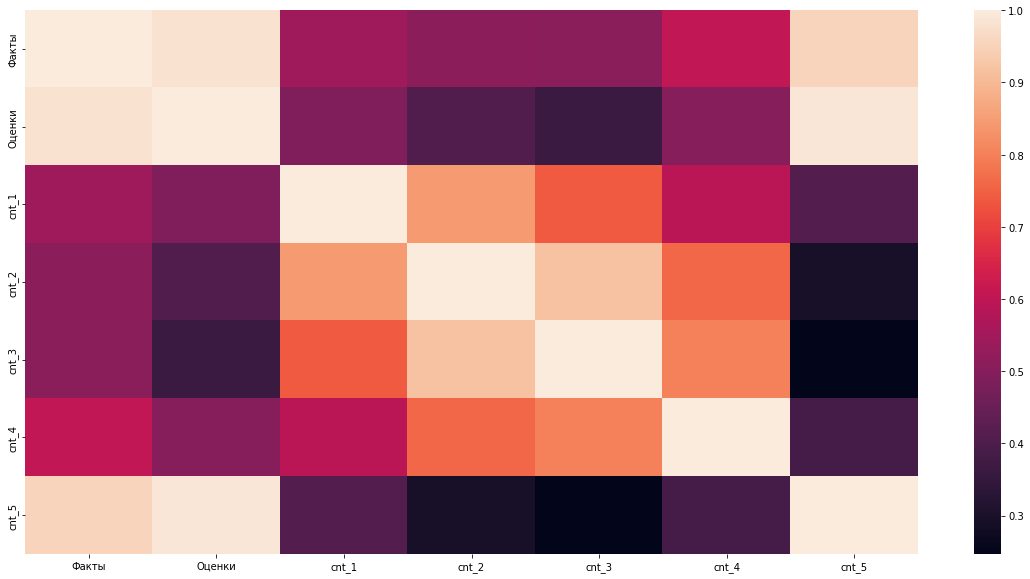

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr())

Видно, что количество оценок коррелирует с количеством оценок "5", значит, существует много ФОИВ, работу которых оценивают исключительно на 5. 
Реже всего же пользователи ставят оценку "3"

И, вероятнее всего, данные, где все оценки являются оценками "5", были накручены

Будем считать 100% наивысших оценок аномально высоким показателем

Уберем такие строки из нашего датафрейма

In [ ]:
df = data[data['Оценки'] != data['cnt_5']]
df.head()

,ФОИВ,Код ТО ФОИВ,ТО ФОИВ,Уод услуги,Услуга,Факты,Оценки,Уровень удовлетворенности,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
0,Департамент по имущественным и земельным отнош...,9200000000162960901,Департамент по имущественным и земельным отнош...,9200000000167723419,Предварительное согласование предоставления зе...,1.0,2.0,"0,00%",2.0,0.0,0.0,0.0,0.0
1,Главное управление потребительского рынка и ли...,9200000000162963760,Главное управление потребительского рынка и ли...,9200000000167690297,Государственная функция по осуществлению регио...,1.0,7.0,"28,57%",1.0,0.0,0.0,0.0,2.0
2,Департамент здравоохранения Ямало-Ненецкого ав...,8900000000000003078,Департамент здравоохранения Ямало-Ненецкого ав...,8900400000000002972,Запись на прием к врачу в медицинскую организа...,3.0,15.0,"6,67%",12.0,2.0,0.0,1.0,0.0
3,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000010000025881,Выплата средств (части средств) материнского (...,514.0,2717.0,"95,99%",42.0,28.0,39.0,70.0,2538.0
4,Служба записи актов гражданского состояния Яма...,8900000010000003335,Служба записи актов гражданского состояния Яма...,8900000010000004597,Выдача повторных свидетельств о государственно...,123.0,655.0,"100,00%",0.0,0.0,0.0,6.0,649.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23200 entries, 0 to 48785
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ФОИВ                       23200 non-null  object 
 1   Код ТО ФОИВ                23200 non-null  object 
 2   ТО ФОИВ                    23200 non-null  object 
 3   Уод услуги                 23200 non-null  object 
 4   Услуга                     23200 non-null  object 
 5   Факты                      23200 non-null  float64
 6   Оценки                     23200 non-null  float64
 7   Уровень удовлетворенности  23200 non-null  object 
 8   cnt_1                      23200 non-null  float64
 9   cnt_2                      23200 non-null  float64
 10  cnt_3                      23200 non-null  float64
 11  cnt_4                      23200 non-null  float64
 12  cnt_5                      23200 non-null  float64
dtypes: float64(7), object(6)
memory usage: 2.5+ MB

Также, вероятнее всего, накрутокой являются те строки, в которых сумма оценок "1" и "5" равно общему количеству оценок данной услуги

Странно, что одну и ту же услугу в одном и том же месте пользователи оценивают так полярно, причем не ставя оценки "2", "3" и "4"

Найдем такие строки:

In [ ]:
df_n = df[df['Оценки'] == df['cnt_5'] + df['cnt_1']]
df_tn = df_n[df_n['Оценки'] != df_n['cnt_1']]
df_tn.head()

,ФОИВ,Код ТО ФОИВ,ТО ФОИВ,Уод услуги,Услуга,Факты,Оценки,Уровень удовлетворенности,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
48,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000000162378272,Назначение и выплата пособия по беременности и...,6.0,27.0,"88,89%",3.0,0.0,0.0,0.0,24.0
50,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000000162378252,Оформление и выдача удостоверений члена семьи ...,4.0,23.0,"73,91%",6.0,0.0,0.0,0.0,17.0
64,Администрация города Новый Уренгой,8900000000160105131,Администрация города Новый Уренгой,8900000000160819022,Выдача разрешений на ввод объектов в эксплуатацию,3.0,9.0,"66,67%",3.0,0.0,0.0,0.0,6.0
84,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000000000002546,"Оформление и выдача удостоверений гражданам, п...",19.0,95.0,"93,68%",6.0,0.0,0.0,0.0,89.0
124,Комитет архитектуры и градостроительства админ...,8600000010000304203,Комитет архитектуры и градостроительства админ...,8600000010005733461,Выдача разрешения на ввод объекта в эксплуатац...,2.0,4.0,"75,00%",1.0,0.0,0.0,0.0,3.0


In [ ]:
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1269 entries, 48 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ФОИВ                       1269 non-null   object 
 1   Код ТО ФОИВ                1269 non-null   object 
 2   ТО ФОИВ                    1269 non-null   object 
 3   Уод услуги                 1269 non-null   object 
 4   Услуга                     1269 non-null   object 
 5   Факты                      1269 non-null   float64
 6   Оценки                     1269 non-null   float64
 7   Уровень удовлетворенности  1269 non-null   object 
 8   cnt_1                      1269 non-null   float64
 9   cnt_2                      1269 non-null   float64
 10  cnt_3                      1269 non-null   float64
 11  cnt_4                      1269 non-null   float64
 12  cnt_5                      1269 non-null   float64
dtypes: float64(7), object(6)
memory usage: 138.8+ 

Их оказалось 1269, уберем их из нашего датафрейма:

In [ ]:
df = df[df['Оценки'] != df['cnt_5'] + df['cnt_1']]
df.head()

,ФОИВ,Код ТО ФОИВ,ТО ФОИВ,Уод услуги,Услуга,Факты,Оценки,Уровень удовлетворенности,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
1,Главное управление потребительского рынка и ли...,9200000000162963760,Главное управление потребительского рынка и ли...,9200000000167690297,Государственная функция по осуществлению регио...,1.0,7.0,"28,57%",1.0,0.0,0.0,0.0,2.0
2,Департамент здравоохранения Ямало-Ненецкого ав...,8900000000000003078,Департамент здравоохранения Ямало-Ненецкого ав...,8900400000000002972,Запись на прием к врачу в медицинскую организа...,3.0,15.0,"6,67%",12.0,2.0,0.0,1.0,0.0
3,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000010000025881,Выплата средств (части средств) материнского (...,514.0,2717.0,"95,99%",42.0,28.0,39.0,70.0,2538.0
4,Служба записи актов гражданского состояния Яма...,8900000010000003335,Служба записи актов гражданского состояния Яма...,8900000010000004597,Выдача повторных свидетельств о государственно...,123.0,655.0,"100,00%",0.0,0.0,0.0,6.0,649.0
5,Департамент здравоохранения Ямало-Ненецкого ав...,8900000000000003078,Департамент здравоохранения Ямало-Ненецкого ав...,8900000010000004595,Лицензирование (в части предоставления и перео...,1.0,7.0,"28,57%",1.0,0.0,0.0,0.0,2.0


Также удалось заметить, что оценки не везде соответствуют сумме оценок по баллам

Является ли это просто ошибкой или накруткой - неизвестно, но в любом случае такие строки тоже нужно убрать

In [ ]:
df = df[df['Оценки'] == df['cnt_1'] + df['cnt_2'] + df['cnt_3'] + df['cnt_4'] + df['cnt_5']]
df.head()

,ФОИВ,Код ТО ФОИВ,ТО ФОИВ,Уод услуги,Услуга,Факты,Оценки,Уровень удовлетворенности,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
2,Департамент здравоохранения Ямало-Ненецкого ав...,8900000000000003078,Департамент здравоохранения Ямало-Ненецкого ав...,8900400000000002972,Запись на прием к врачу в медицинскую организа...,3.0,15.0,"6,67%",12.0,2.0,0.0,1.0,0.0
3,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000010000025881,Выплата средств (части средств) материнского (...,514.0,2717.0,"95,99%",42.0,28.0,39.0,70.0,2538.0
4,Служба записи актов гражданского состояния Яма...,8900000010000003335,Служба записи актов гражданского состояния Яма...,8900000010000004597,Выдача повторных свидетельств о государственно...,123.0,655.0,"100,00%",0.0,0.0,0.0,6.0,649.0
7,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000010000002817,Предоставление гражданам субсидий на оплату жи...,1387.0,6897.0,"96,90%",71.0,43.0,100.0,314.0,6369.0
8,Департамент социальной защиты населения Ямало-...,8900000000000003124,Департамент социальной защиты населения Ямало-...,8900000010000002652,Предоставление государственной социальной помо...,6539.0,33316.0,"97,24%",359.0,163.0,397.0,1763.0,30634.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21228 entries, 2 to 48785
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ФОИВ                       21228 non-null  object 
 1   Код ТО ФОИВ                21228 non-null  object 
 2   ТО ФОИВ                    21228 non-null  object 
 3   Уод услуги                 21228 non-null  object 
 4   Услуга                     21228 non-null  object 
 5   Факты                      21228 non-null  float64
 6   Оценки                     21228 non-null  float64
 7   Уровень удовлетворенности  21228 non-null  object 
 8   cnt_1                      21228 non-null  float64
 9   cnt_2                      21228 non-null  float64
 10  cnt_3                      21228 non-null  float64
 11  cnt_4                      21228 non-null  float64
 12  cnt_5                      21228 non-null  float64
dtypes: float64(7), object(6)
memory usage: 2.3+ MB

Таким образом, по нашим расчетам, получился датасет без накруток


Скачаем его, чтобы посторить диаграммы общей статистики теперь для данных без накрутки для сравнения с исходными данными

In [ ]:
from google.colab import files
df.to_excel('new_df.xlsx')
files.download('new_df.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://datastudio.google.com/u/0/reporting/cfd316ca-a58d-40c2-96f7-5c2b7c1ecb77/page/ANghC - диаграммы здесь